In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [8]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

df = pd.read_csv("fraud_reduced.csv", index_col=0)

In [7]:
smote = SMOTE(sampling_strategy=0.5)

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.33, stratify=y)

X_train,y_train = smote.fit_resample(X,y)

In [12]:
param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),   
}

rnd_clf = ExtraTreesClassifier(n_jobs=-1)
param_search = RandomizedSearchCV(
    rnd_clf,
    param_distributions=param_grid,
    n_iter=10,  # Adjust the number of iterations as needed
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=None),  # Cross-validation strategy
    n_jobs=1,  # Use all available CPU cores
    random_state=42,
    scoring = make_scorer(roc_auc_score, needs_threshold=True)
)

param_search.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=ExtraTreesClassifier(n_jobs=-1), n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000284722B2050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000284723BEB90>},
                   random_state=42,
                   scoring=make_scorer(roc_auc_score, needs_threshold=True))

In [13]:
cvres = param_search.cv_results_
results = [(mean_score, params) for mean_score, params in zip(cvres["mean_test_score"], cvres["params"])]
results.sort(reverse=True, key=lambda x: x[0])
for mean_score, params in results:
    print("ROC AUC", mean_score, "-", "Parameters:", params)

ROC AUC 0.9971083579590931 - Parameters: {'max_depth': 19, 'n_estimators': 156}
ROC AUC 0.9901279043214719 - Parameters: {'max_depth': 15, 'n_estimators': 137}
ROC AUC 0.9820653903486682 - Parameters: {'max_depth': 12, 'n_estimators': 180}
ROC AUC 0.981602420782334 - Parameters: {'max_depth': 12, 'n_estimators': 70}
ROC AUC 0.9794615058591744 - Parameters: {'max_depth': 11, 'n_estimators': 171}
ROC AUC 0.9788983169450267 - Parameters: {'max_depth': 11, 'n_estimators': 142}
ROC AUC 0.9761930729415124 - Parameters: {'max_depth': 10, 'n_estimators': 102}
ROC AUC 0.9729522876307763 - Parameters: {'max_depth': 9, 'n_estimators': 149}
ROC AUC 0.9673087653745928 - Parameters: {'max_depth': 7, 'n_estimators': 124}
ROC AUC 0.9649801032605113 - Parameters: {'max_depth': 6, 'n_estimators': 137}


In [14]:
param_search.best_estimator_

ExtraTreesClassifier(max_depth=19, n_estimators=156, n_jobs=-1)

In [15]:
clf_ext = param_search.best_estimator_

In [16]:
y_pred = clf_ext.predict(X_test)

[[93787    38]
 [   20   142]]


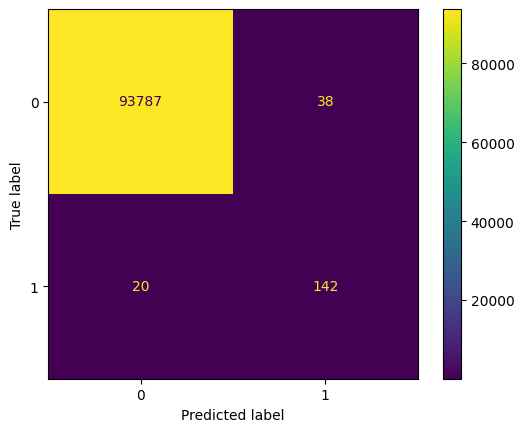

In [18]:

cm = confusion_matrix(y_test, y_pred)
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_ext.classes_)
disp.plot()

In [19]:
y_pred = clf_ext.predict(X_test)

# Calculate and display classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.79      0.88      0.83       162

    accuracy                           1.00     93987
   macro avg       0.89      0.94      0.92     93987
weighted avg       1.00      1.00      1.00     93987



In [20]:
import joblib 


joblib.dump(value= clf_ext, filename='Extra_trees.pkl')

['Extra_trees.pkl']